In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


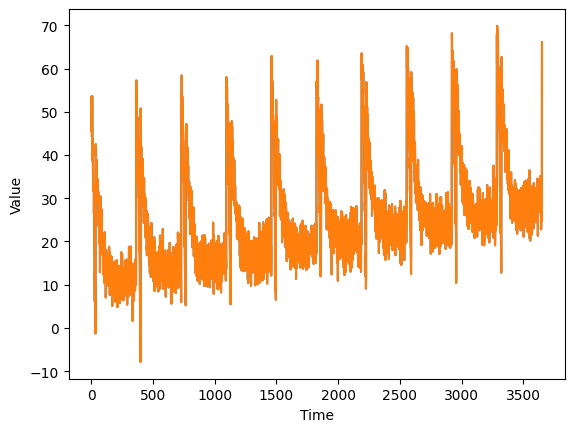

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)
plt.show()

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, validation_data=val_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 10s 35ms/step - loss: 67.6944 - mae: 68.1944 - val_loss: 65.9871 - val_mae: 66.4871 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 11ms/step - loss: 60.5482 - mae: 61.0482 - val_loss: 63.0597 - val_mae: 63.5597 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 57.4607 - mae: 57.9607 - val_loss: 59.7270 - val_mae: 60.2270 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 1s 11ms/step - loss: 53.9956 - mae: 54.4957 - val_loss: 55.9876 - val_mae: 56.4876 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 1s 10ms/step - loss: 50.0965 - mae: 50.5965 - val_loss: 51.7724 - val_mae: 52.2724 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 45.7082 - mae: 46.2082 - val_loss: 47.0309 - val_mae: 47.5309 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 1s 11ms/step - loss: 40.7670

94/94 [==============================] - 1s 10ms/step - loss: 3.0576 - mae: 3.5216 - val_loss: 2.8857 - val_mae: 3.3535 - lr: 5.0119e-06
Epoch 56/100
94/94 [==============================] - 1s 11ms/step - loss: 3.0404 - mae: 3.5051 - val_loss: 3.8313 - val_mae: 4.3116 - lr: 5.6234e-06
Epoch 57/100
94/94 [==============================] - 1s 11ms/step - loss: 3.2826 - mae: 3.7500 - val_loss: 2.9372 - val_mae: 3.4006 - lr: 6.3096e-06
Epoch 58/100
94/94 [==============================] - 1s 11ms/step - loss: 2.9471 - mae: 3.4082 - val_loss: 2.9056 - val_mae: 3.3695 - lr: 7.0795e-06
Epoch 59/100
94/94 [==============================] - 1s 10ms/step - loss: 2.9526 - mae: 3.4197 - val_loss: 2.7735 - val_mae: 3.2394 - lr: 7.9433e-06
Epoch 60/100
94/94 [==============================] - 1s 10ms/step - loss: 3.1156 - mae: 3.5835 - val_loss: 3.1595 - val_mae: 3.6256 - lr: 8.9125e-06
Epoch 61/100
94/94 [==============================] - 1s 11ms/step - loss: 3.0346 - mae: 3.5006 - val_loss: 2.817

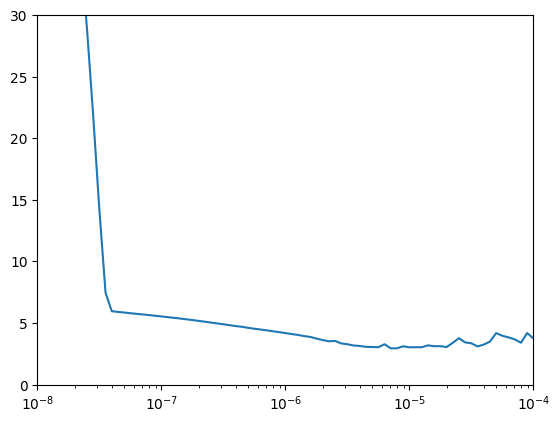

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()
# FROM THIS PICK A LEARNING RATE

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))
history = model.fit(dataset, validation_data=val_set, epochs=500)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 9s 31ms/step - loss: 263.1988 - val_loss: 48.8091
Epoch 2/500
94/94 [==============================] - 1s 11ms/step - loss: 33.6153 - val_loss: 25.1750
Epoch 3/500
94/94 [==============================] - 1s 11ms/step - loss: 27.7103 - val_loss: 24.8452
Epoch 4/500
94/94 [==============================] - 1s 11ms/step - loss: 31.9160 - val_loss: 27.1264
Epoch 5/500
94/94 [==============================] - 1s 11ms/step - loss: 27.1127 - val_loss: 24.7539
Epoch 6/500
94/94 [==============================] - 1s 11ms/step - loss: 25.7764 - val_loss: 46.5362
Epoch 7/500
94/94 [==============================] - 1s 11ms/step - loss: 32.1397 - val_loss: 42.5731
Epoch 8/500
94/94 [==============================] - 1s 11ms/step - loss: 27.8369 - val_loss: 22.7893
Epoch 9/500
94/94 [==============================] - 1s 11ms/step - loss: 29.2938 - val_loss: 24.6883
Epoch 10/500
94/94 [==============================] - 1s 11ms/step - loss: 28.073

94/94 [==============================] - 1s 10ms/step - loss: 22.8248 - val_loss: 27.5837
Epoch 81/500
94/94 [==============================] - 1s 11ms/step - loss: 23.3678 - val_loss: 23.1782
Epoch 82/500
94/94 [==============================] - 1s 11ms/step - loss: 23.6418 - val_loss: 36.5073
Epoch 83/500
94/94 [==============================] - 1s 11ms/step - loss: 24.2519 - val_loss: 21.2347
Epoch 84/500
94/94 [==============================] - 1s 10ms/step - loss: 22.8469 - val_loss: 22.0422
Epoch 85/500
94/94 [==============================] - 1s 11ms/step - loss: 21.5177 - val_loss: 21.8305
Epoch 86/500
94/94 [==============================] - 1s 10ms/step - loss: 22.5515 - val_loss: 20.7287
Epoch 87/500
94/94 [==============================] - 1s 10ms/step - loss: 24.2311 - val_loss: 21.8019
Epoch 88/500
94/94 [==============================] - 1s 10ms/step - loss: 21.6834 - val_loss: 21.2493
Epoch 89/500
94/94 [==============================] - 1s 11ms/step - loss: 23.2963 - v

94/94 [==============================] - 1s 10ms/step - loss: 21.6414 - val_loss: 28.3231
Epoch 160/500
94/94 [==============================] - 1s 10ms/step - loss: 20.5427 - val_loss: 19.8293
Epoch 161/500
94/94 [==============================] - 1s 10ms/step - loss: 22.3396 - val_loss: 20.5247
Epoch 162/500
94/94 [==============================] - 1s 11ms/step - loss: 20.8446 - val_loss: 22.5450
Epoch 163/500
94/94 [==============================] - 1s 10ms/step - loss: 20.9991 - val_loss: 19.9388
Epoch 164/500
94/94 [==============================] - 1s 10ms/step - loss: 21.2175 - val_loss: 35.0551
Epoch 165/500
94/94 [==============================] - 1s 10ms/step - loss: 22.3292 - val_loss: 20.2036
Epoch 166/500
94/94 [==============================] - 1s 10ms/step - loss: 21.0130 - val_loss: 20.2196
Epoch 167/500
94/94 [==============================] - 1s 11ms/step - loss: 20.7085 - val_loss: 20.0691
Epoch 168/500
94/94 [==============================] - 1s 10ms/step - loss: 21

Epoch 238/500
94/94 [==============================] - 1s 10ms/step - loss: 20.3758 - val_loss: 19.5078
Epoch 239/500
94/94 [==============================] - 1s 11ms/step - loss: 20.0553 - val_loss: 22.0116
Epoch 240/500
94/94 [==============================] - 1s 10ms/step - loss: 20.3129 - val_loss: 24.7943
Epoch 241/500
94/94 [==============================] - 1s 10ms/step - loss: 20.9119 - val_loss: 20.1253
Epoch 242/500
94/94 [==============================] - 1s 11ms/step - loss: 21.7406 - val_loss: 19.4853
Epoch 243/500
94/94 [==============================] - 1s 10ms/step - loss: 21.5194 - val_loss: 21.6719
Epoch 244/500
94/94 [==============================] - 1s 11ms/step - loss: 20.9909 - val_loss: 20.5194
Epoch 245/500
94/94 [==============================] - 1s 10ms/step - loss: 20.8095 - val_loss: 19.6447
Epoch 246/500
94/94 [==============================] - ETA: 0s - loss: 20.99 - 1s 11ms/step - loss: 21.1041 - val_loss: 20.3895
Epoch 247/500
94/94 [===================

94/94 [==============================] - 1s 10ms/step - loss: 20.7833 - val_loss: 20.0838
Epoch 317/500
94/94 [==============================] - 1s 10ms/step - loss: 20.9079 - val_loss: 23.3548
Epoch 318/500
94/94 [==============================] - 1s 10ms/step - loss: 20.0565 - val_loss: 27.1240
Epoch 319/500
94/94 [==============================] - 1s 10ms/step - loss: 20.1753 - val_loss: 22.4437
Epoch 320/500
94/94 [==============================] - 1s 11ms/step - loss: 23.1851 - val_loss: 20.4429
Epoch 321/500
94/94 [==============================] - 1s 11ms/step - loss: 20.0141 - val_loss: 22.3213
Epoch 322/500
94/94 [==============================] - 1s 11ms/step - loss: 19.8593 - val_loss: 20.1277
Epoch 323/500
94/94 [==============================] - 1s 11ms/step - loss: 20.6969 - val_loss: 21.5304
Epoch 324/500
94/94 [==============================] - 1s 11ms/step - loss: 22.2788 - val_loss: 21.5076
Epoch 325/500
94/94 [==============================] - 1s 10ms/step - loss: 19

Epoch 395/500
94/94 [==============================] - 1s 10ms/step - loss: 19.4730 - val_loss: 19.5198
Epoch 396/500
94/94 [==============================] - 1s 10ms/step - loss: 19.6056 - val_loss: 19.3196
Epoch 397/500
94/94 [==============================] - 1s 10ms/step - loss: 20.4185 - val_loss: 19.6355
Epoch 398/500
94/94 [==============================] - 1s 10ms/step - loss: 19.4113 - val_loss: 25.3515
Epoch 399/500
94/94 [==============================] - 1s 11ms/step - loss: 21.6251 - val_loss: 19.8658
Epoch 400/500
94/94 [==============================] - 1s 10ms/step - loss: 20.0713 - val_loss: 20.2768
Epoch 401/500
94/94 [==============================] - 1s 10ms/step - loss: 20.0572 - val_loss: 20.2511
Epoch 402/500
94/94 [==============================] - 1s 10ms/step - loss: 19.2695 - val_loss: 20.4708
Epoch 403/500
94/94 [==============================] - 1s 10ms/step - loss: 19.8198 - val_loss: 19.9203
Epoch 404/500
94/94 [==============================] - 1s 11ms/s

Epoch 474/500
94/94 [==============================] - 1s 10ms/step - loss: 20.1848 - val_loss: 19.8273
Epoch 475/500
94/94 [==============================] - 1s 10ms/step - loss: 18.9912 - val_loss: 22.9095
Epoch 476/500
94/94 [==============================] - 1s 10ms/step - loss: 19.2595 - val_loss: 20.3522
Epoch 477/500
94/94 [==============================] - 1s 11ms/step - loss: 21.5276 - val_loss: 19.3323
Epoch 478/500
94/94 [==============================] - 1s 10ms/step - loss: 19.8143 - val_loss: 21.8588
Epoch 479/500
94/94 [==============================] - 1s 10ms/step - loss: 19.7415 - val_loss: 24.3588
Epoch 480/500
94/94 [==============================] - 1s 11ms/step - loss: 20.3447 - val_loss: 19.4910
Epoch 481/500
94/94 [==============================] - 1s 11ms/step - loss: 19.7137 - val_loss: 19.4813
Epoch 482/500
94/94 [==============================] - 1s 10ms/step - loss: 19.6503 - val_loss: 18.9191
Epoch 483/500
94/94 [==============================] - 1s 10ms/s

In [10]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# YOUR RESULT HERE SHOULD BE LESS THAN 4

19.030287
2.9205344


In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

KeyError: 'mae'